# Imports

In [1]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login()

2024-06-18 14:18:01.675696: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvaro-francisco-gil (orbit-generation). Use `wandb login --relogin` to force relogin


True

In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)



GPUs found: 3
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU 2: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-06-18 14:18:05.916739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 14:18:06.805212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:99:00.0, compute capability: 8.6


In [3]:
from orbit_generation.constants import EM_MU
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits
from orbit_generation.stats import plot_histograms_comparison, plot_latent_space, plot_combined_latent_space
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model import get_optimizer
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment, convert_notebook, add_experiment_metrics

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
import tsgm
import os

2024-06-18 14:18:17.022381: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-18 14:18:17.024892: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7e09120


# Parameters

In [5]:
want_to_train = True        # Set this parameter to False if you want to load the model from the folder
want_to_generate = True     # Set this parameter to False if you want to load the generation from the folder

In [6]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [7]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 300,
    'batch_size': 32,
    'epochs': 25,
    'optimizer': {
        'name': 'Adam',
        'learning_rate': 0.001
    },
    'num_samples': 100
}

In [8]:
if want_to_train:
    # Initialize a new run
    wandb.init(project='orbit-generation', entity='alvaro-francisco-gil', config=params)

wandb: Currently logged in as: alvaro-francisco-gil. Use `wandb login --relogin` to force relogin


# Data

## Import

In [9]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 300)

## Shuffle

In [10]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
data = data[indices]
labels = np.array(labels)
labels = labels[indices]

## Transpose

In [11]:
transposed_orbits = np.transpose(data, (0, 2, 1))

## Scaling

In [12]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(45211, 300, 7)

# Modelling

## Define Architecture

In [13]:
if want_to_train:
    # Accessing model configuration from the zoo using parameters from the dictionary
    architecture = tsgm.models.zoo[params['model_name']](
        seq_len=params['seq_len'], 
        feat_dim=scaled_data.shape[2], 
        latent_dim=params['latent_dim']
    )

    # Extracting encoder and decoder from the architecture
    encoder, decoder = architecture.encoder, architecture.decoder

    # Build the VAE
    vae = tsgm.models.cvae.BetaVAE(encoder, decoder)

## Training

In [ ]:
if want_to_train:

    metrics = {}

    # Compile the VAE model with the configured optimizer from the params dictionary
    optimizer = get_optimizer(params['optimizer'])
    vae.compile(optimizer=optimizer)

    # Fit the model using the scaled data and parameters from the dictionary
    # Use validation_split to reserve a portion of the data for validation
    history = vae.fit(scaled_data, 
                      epochs=params['epochs'], 
                      batch_size=params['batch_size'], 
                      validation_split=0.2,  # Adjust the split ratio as needed
                      callbacks=[WandbCallback()])

    # Extract metrics from the training history and add to the metrics dictionary
    metrics['loss'] = history.history['loss'][-1]
    if 'reconstruction_loss' in history.history:
        metrics['reconstruction_loss'] = history.history['reconstruction_loss'][-1]
    if 'kl_loss' in history.history:
        metrics['kl_loss'] = history.history['kl_loss'][-1]
    if 'val_loss' in history.history:
        metrics['val_loss'] = history.history['val_loss'][-1]
    if 'val_reconstruction_loss' in history.history:
        metrics['val_reconstruction_loss'] = history.history['val_reconstruction_loss'][-1]
    if 'val_kl_loss' in history.history:
        metrics['val_kl_loss'] = history.history['val_kl_loss'][-1]

In [14]:
if want_to_train:

    metrics = {}

    # Compile the VAE model with the configured optimizer from the params dictionary
    optimizer = get_optimizer(params['optimizer'])
    vae.compile(optimizer=optimizer)

    # Fit the model using the scaled data and parameters from the dictionary
    history = vae.fit(scaled_data, epochs=params['epochs'], batch_size=params['batch_size'], callbacks=[WandbCallback()])

    # Extract metrics from the training history and add to the metrics dictionary
    metrics['loss'] = history.history['loss'][-1]
    if 'reconstruction_loss' in history.history:
        metrics['reconstruction_loss'] = history.history['reconstruction_loss'][-1]
    if 'kl_loss' in history.history:
        metrics['kl_loss'] = history.history['kl_loss'][-1]
    if 'val_loss' in history.history:
        metrics['val_loss'] = history.history['val_loss'][-1]
    if 'val_reconstruction_loss' in history.history:
        metrics['val_reconstruction_loss'] = history.history['val_reconstruction_loss'][-1]
    if 'val_kl_loss' in history.history:
        metrics['val_kl_loss'] = history.history['val_kl_loss'][-1]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25


2024-06-18 14:19:26.274992: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1413/1413 [==============================] - 93s 62ms/step - loss: 262.7329 - reconstruction_loss: 134.7797 - kl_loss: 6.2630
Epoch 2/25
1413/1413 [==============================] - 88s 62ms/step - loss: 43.8326 - reconstruction_loss: 38.4128 - kl_loss: 6.9704
Epoch 3/25
1413/1413 [==============================] - 87s 62ms/step - loss: 33.5741 - reconstruction_loss: 27.4647 - kl_loss: 6.9693
Epoch 4/25
1413/1413 [==============================] - 87s 62ms/step - loss: 51.8757 - reconstruction_loss: 39.1967 - kl_loss: 7.0476
Epoch 5/25
1413/1413 [==============================] - 88s 62ms/step - loss: 28.0954 - reconstruction_loss: 21.2283 - kl_loss: 7.2292
Epoch 6/25
1413/1413 [==============================] - 88s 62ms/step - loss: 20.6942 - reconstruction_loss: 13.3648 - kl_loss: 7.0505
Epoch 7/25
1413/1413 [==============================] - 87s 62ms/step - loss: 21.9228 - reconstruction_loss: 15.2321 - kl_loss: 7.1370
Epoch 8/25
1413/1413 [==============================] - 87s 61ms

## Saving

In [15]:
experiment_folder = setup_new_experiment(params, experiments_folder)

New experiment setup complete: ../experiments/experiment_2
Parameters saved to ../experiments/experiments.csv.


In [17]:
add_experiment_metrics(params, metrics, experiments_folder)

ValueError: Experiment with the specified parameters does not exist.

In [18]:
# Define full paths for saving
encoder_save_path = os.path.join(experiment_folder, 'encoder')
decoder_save_path = os.path.join(experiment_folder, 'decoder')
generated_data_path = os.path.join(experiment_folder, 'generated_data.npy')
static_all_orbit_path = os.path.join(experiment_folder, 'all_generated_data.png')
static_some_orbit_path = os.path.join(experiment_folder, 'some_generated_data.png')
dynamic_orbits_path = os.path.join(experiment_folder, 'generated_orbits.html')
latent_representations_path = os.path.join(experiment_folder, 'latent_representations.npy')
sampled_latent_representations_path = os.path.join(experiment_folder, 'sampled_latent_representations.npy')
labels_latent_representations_path = os.path.join(experiment_folder, 'labels_latent_representations.npy')
labels_sampled_latent_representations_path = os.path.join(experiment_folder, 'labels_sampled_latent_representations.npy')
latent_space_path = os.path.join(experiment_folder, 'dimensionality_reduction_latent_space')
combined_latent_space_path = os.path.join(experiment_folder, 'combined_dimensionality_reduction_latent_space')

In [19]:
if want_to_train:
    # Save the models in the specified directory with TensorFlow format
    encoder.save(encoder_save_path, save_format='tf')
    decoder.save(decoder_save_path, save_format='tf')

INFO:tensorflow:Assets written to: ../experiments/experiment_2/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment_2/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment_2/decoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment_2/decoder/assets


In [20]:
if not want_to_train:
    # Load models
    encoder = tf.keras.models.load_model(encoder_save_path)
    decoder = tf.keras.models.load_model(decoder_save_path)

    # Build VAE
    vae = tsgm.models.cvae.BetaVAE(encoder, decoder)

## Generate

In [21]:
if want_to_generate:
    # Generate the orbits
    generation = vae.generate(params['num_samples'])
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

TensorShape([100, 300, 7])

In [22]:
inverted_generation = scaler.inverse_transform(generation)
np.save(generated_data_path, inverted_generation)
inverted_generation.shape

TensorShape([100, 300, 7])

# Analysis of Generation

## Visualization

In [23]:
if inverted_generation.shape[2] == 7:
    inverted2_generation = inverted_generation[:,:,1:]
    inverted2_generation.shape
else:
    inverted2_generation = inverted_generation

display_generation = np.transpose(inverted2_generation, (0, 2, 1))
display_generation.shape

(100, 6, 300)

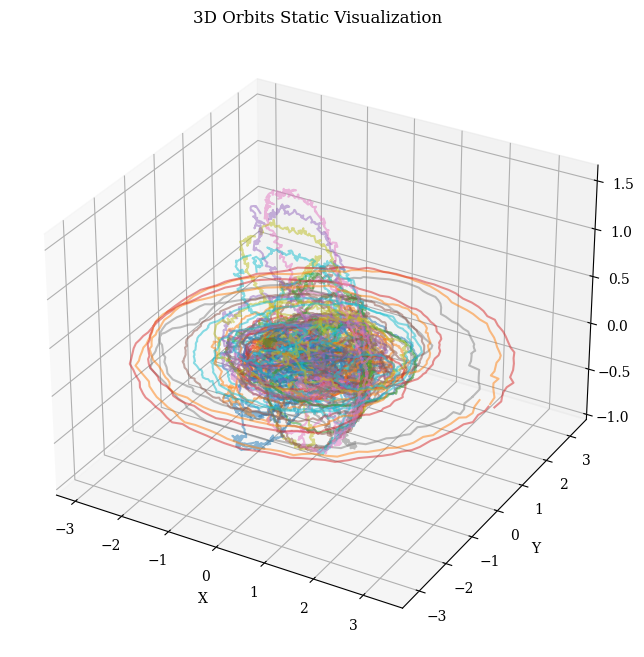

In [24]:
visualize_static_orbits(data= display_generation, show_legend=False, save_path=static_all_orbit_path)

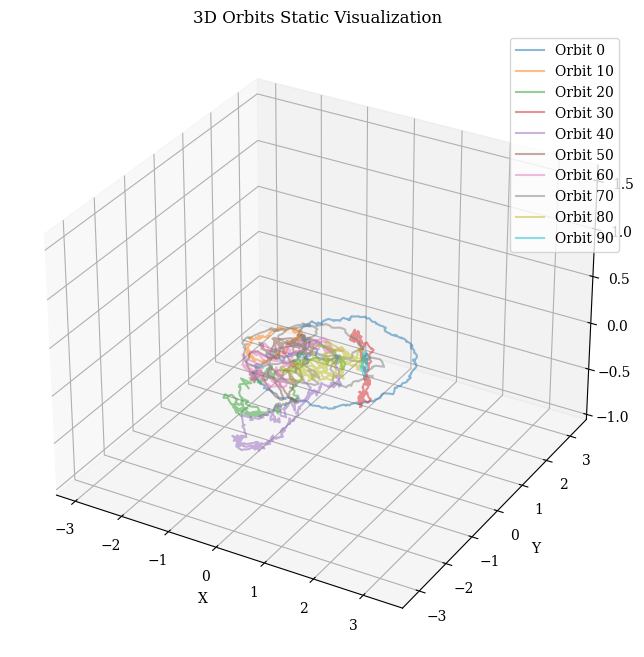

In [25]:
visualize_static_orbits(data= display_generation, orbit_indices=[0,10,20,30,40,50,60,70,80,90], save_path=static_some_orbit_path)

In [26]:
export_dynamic_orbits_html(data=display_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_2/generated_orbits.html


## Coverage

In [27]:
data.shape

(45211, 7, 300)

In [28]:
inverted_ordered_generation = np.transpose(inverted_generation, (0, 2, 1))
inverted_ordered_generation.shape

(100, 7, 300)

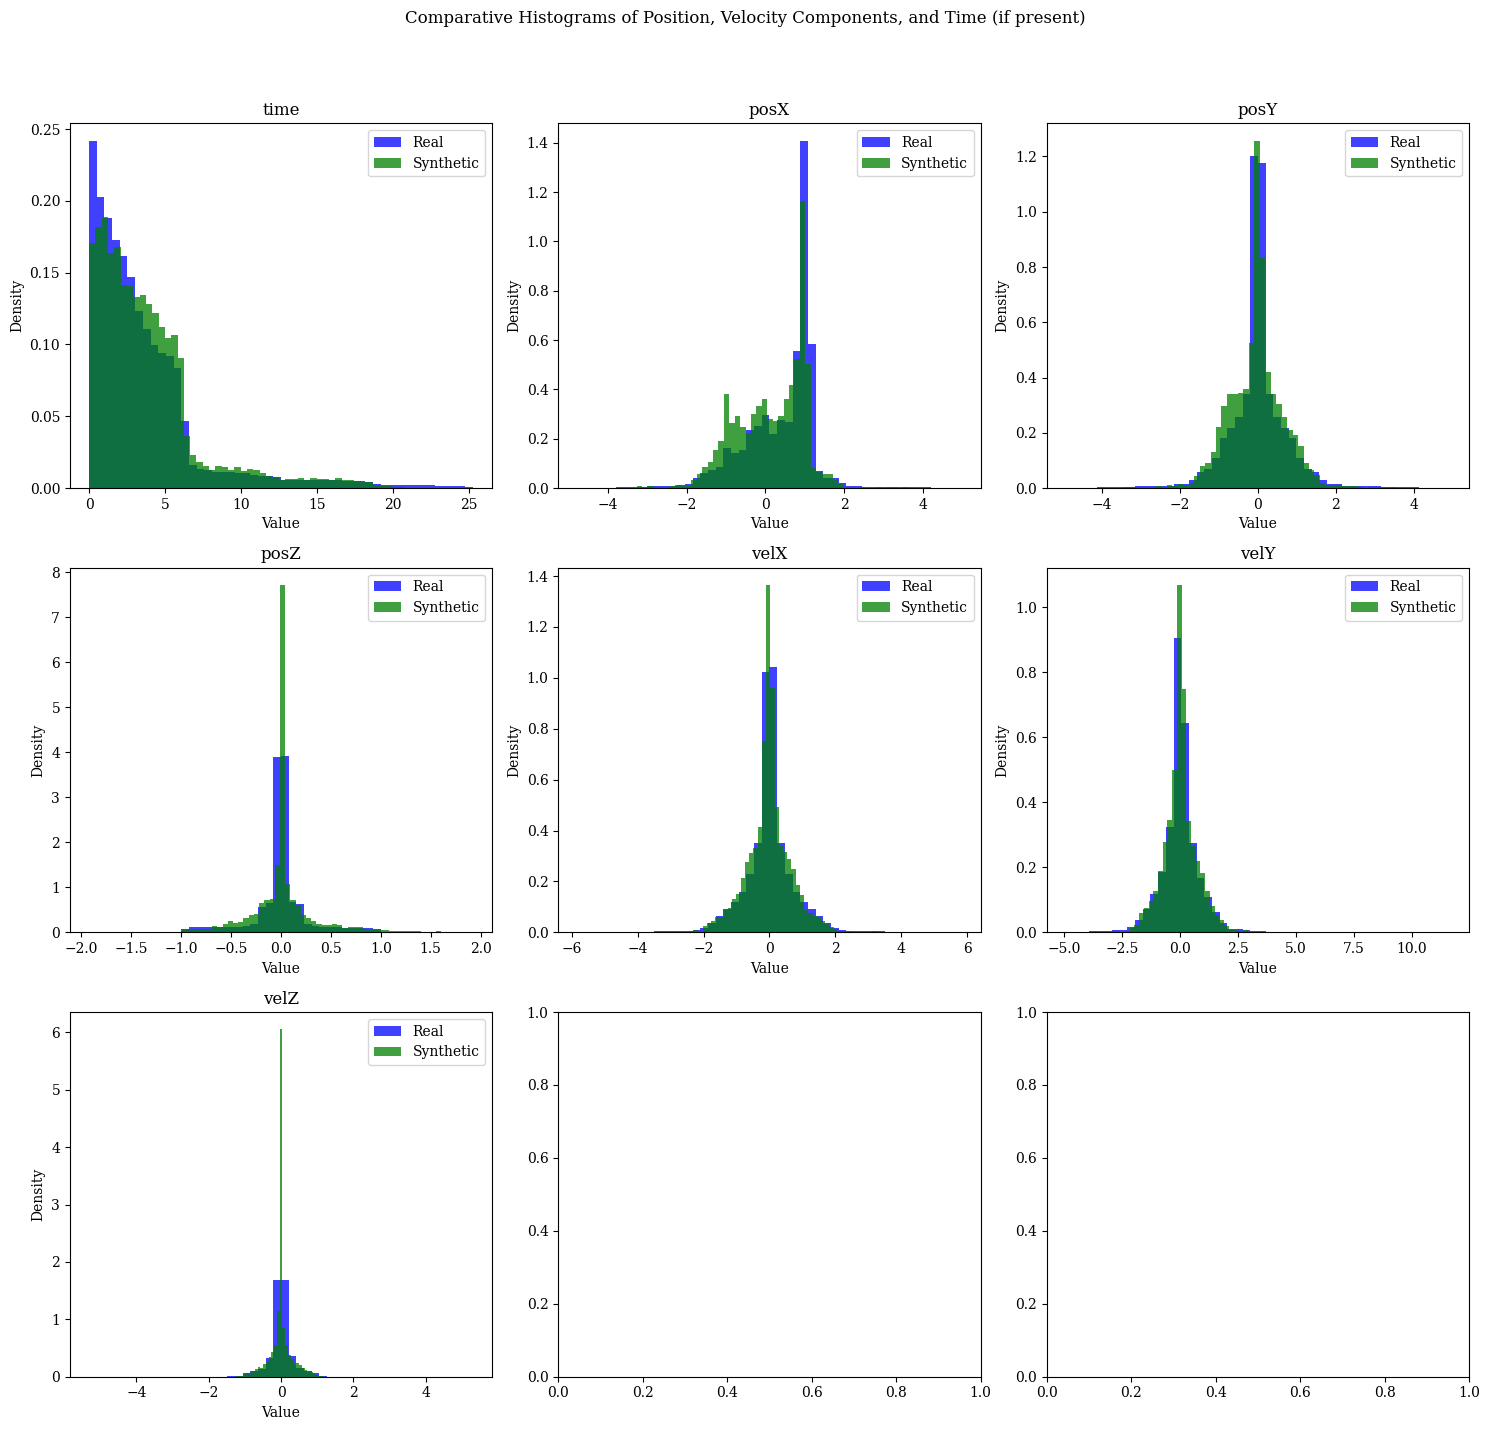

In [29]:
plot_histograms_comparison(data1=data, data2=inverted_ordered_generation, label1='Real', label2='Synthetic', normalize=True)

## Pheasibility

Cumulative position error for selected orbits: 3787.6337812963334
Average position error per time step: 12.667671509352285


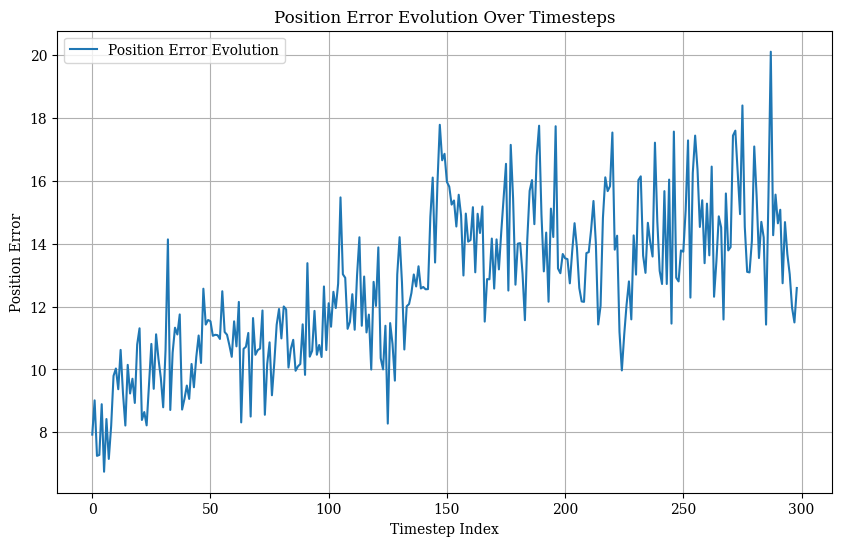

Cumulative velocity error for selected orbits: 6282.18062056344
Average velocity error per time step: 21.01063752696803


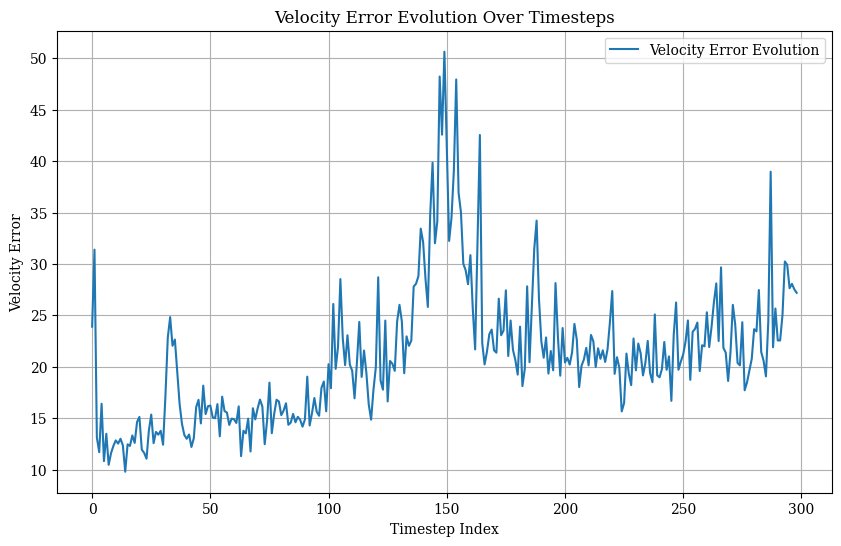

Cumulative energy error for selected orbits: 16619.89112229235
Average energy error per time step: 55.584920141445984


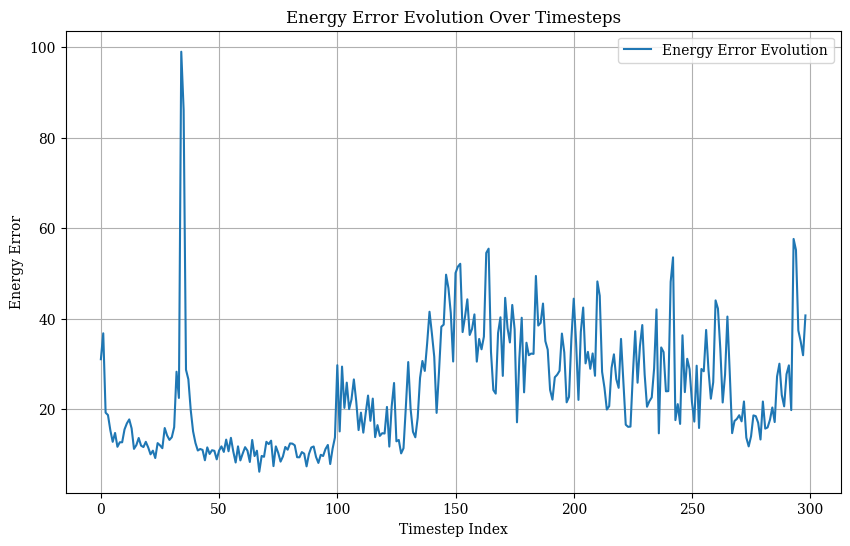

ValueError: Experiment with the specified parameters does not exist.

In [30]:
## add model metrics
reordered_orbits, order_metrics = reorder_orbits(inverted_ordered_generation)
errors = calculate_errors(reordered_orbits,EM_MU,time_step=0.01)

In [ ]:

# Add order
add_experiment_metrics(params, {**errors, **order_metrics}, experiments_folder)

# Latent Visualization

## Sampling

In [31]:
np.random.seed(42)

# Randomly choose indices
random_indices = np.random.choice(data.shape[0], size=5000, replace=False)

# Select the samples
sampled_data = scaled_data[random_indices]
sampled_labels = labels[random_indices]

sampled_data.shape

(5000, 300, 7)

In [32]:
latent_mean, latent_deviation, latent_epsilon = vae.encoder(sampled_data)
sampled_latent_representations = latent_mean.numpy()

np.save(sampled_latent_representations_path, sampled_latent_representations)
np.save(labels_sampled_latent_representations_path, sampled_labels)

sampled_latent_representations.shape

(5000, 2)

In [33]:
sampled_id_classes = [orbit_df.at[index, 'id_class'] for index in sampled_labels]
sampled_classes=get_orbit_classes(sampled_id_classes)

## Orbit Classifications

Saved plot to ../experiments/experiment_2/dimensionality_reduction_latent_space_label_PCA.png


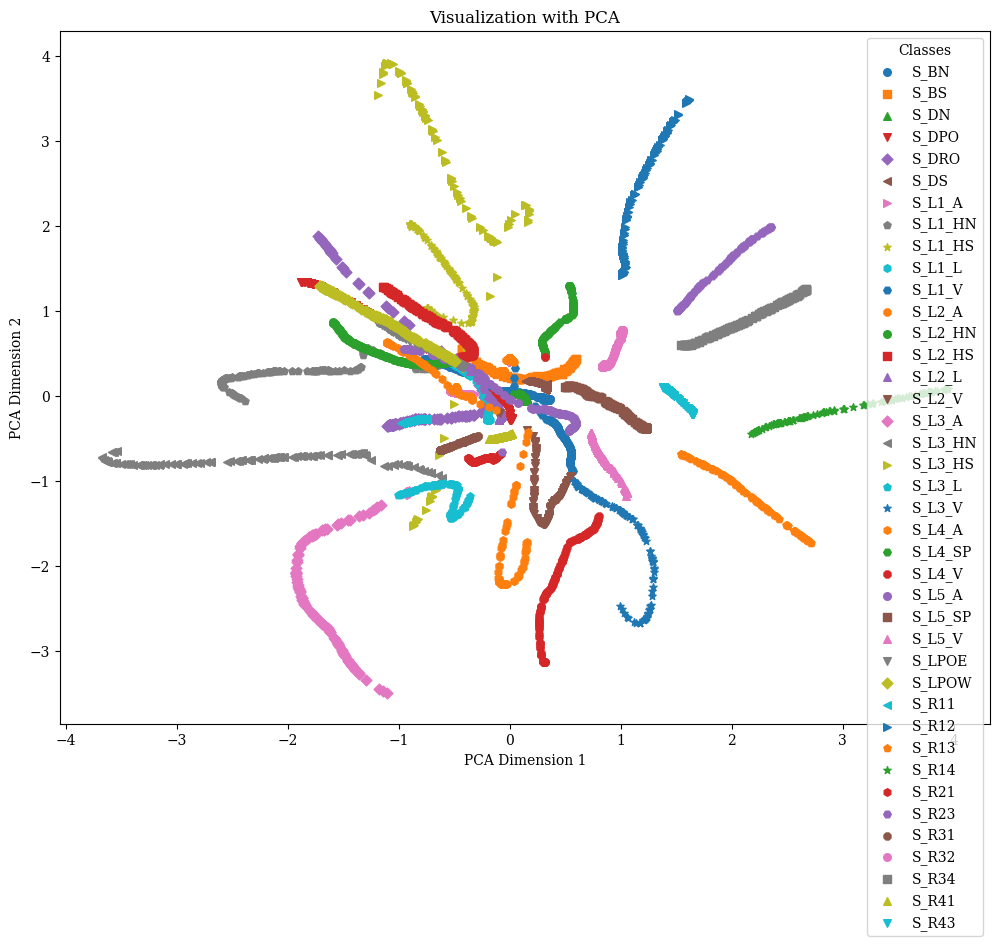

Saved plot to ../experiments/experiment_2/dimensionality_reduction_latent_space_label_t-SNE.png


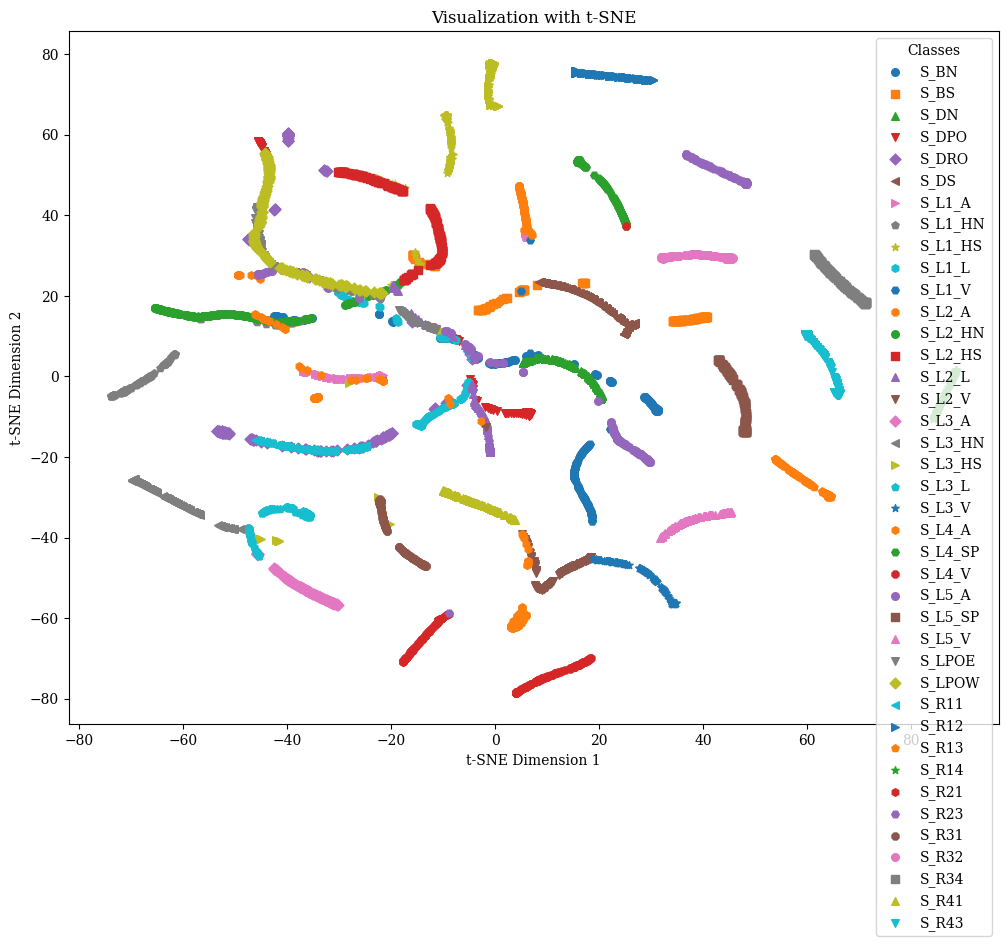

Saved plot to ../experiments/experiment_2/dimensionality_reduction_latent_space_label_UMAP.png


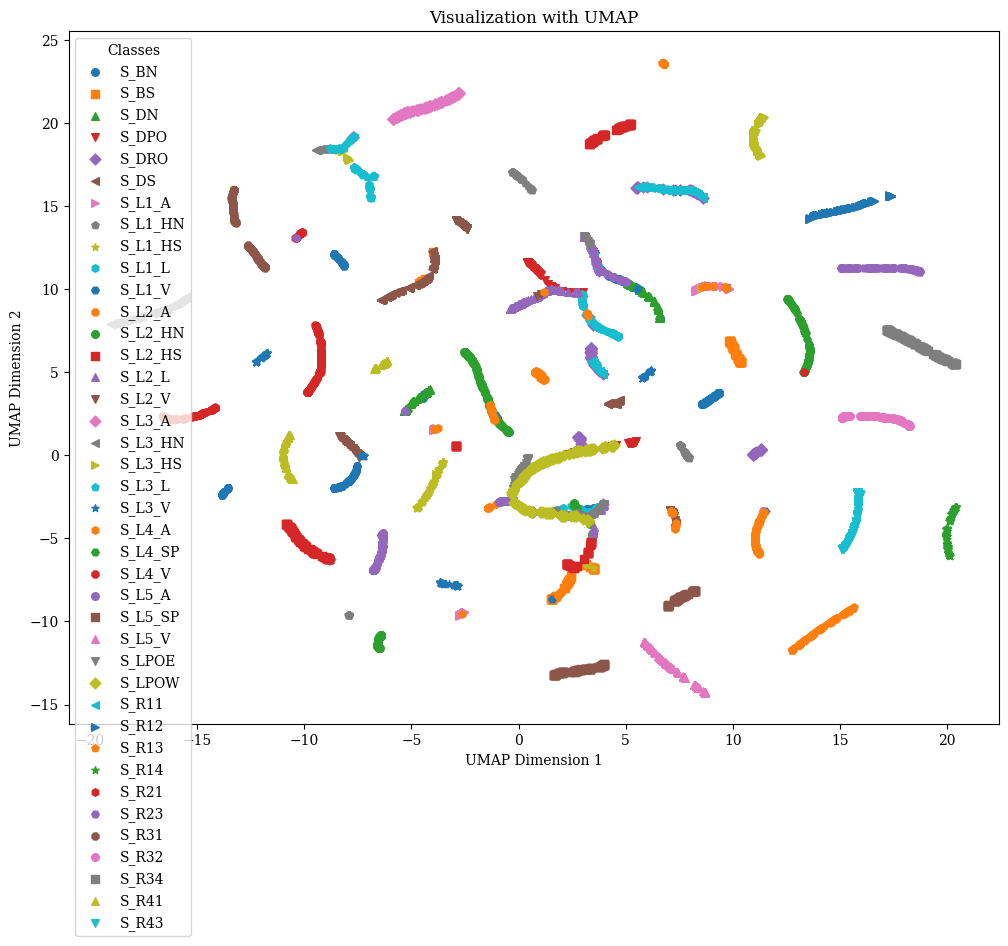

Saved plot to ../experiments/experiment_2/dimensionality_reduction_latent_space_label_LDA.png


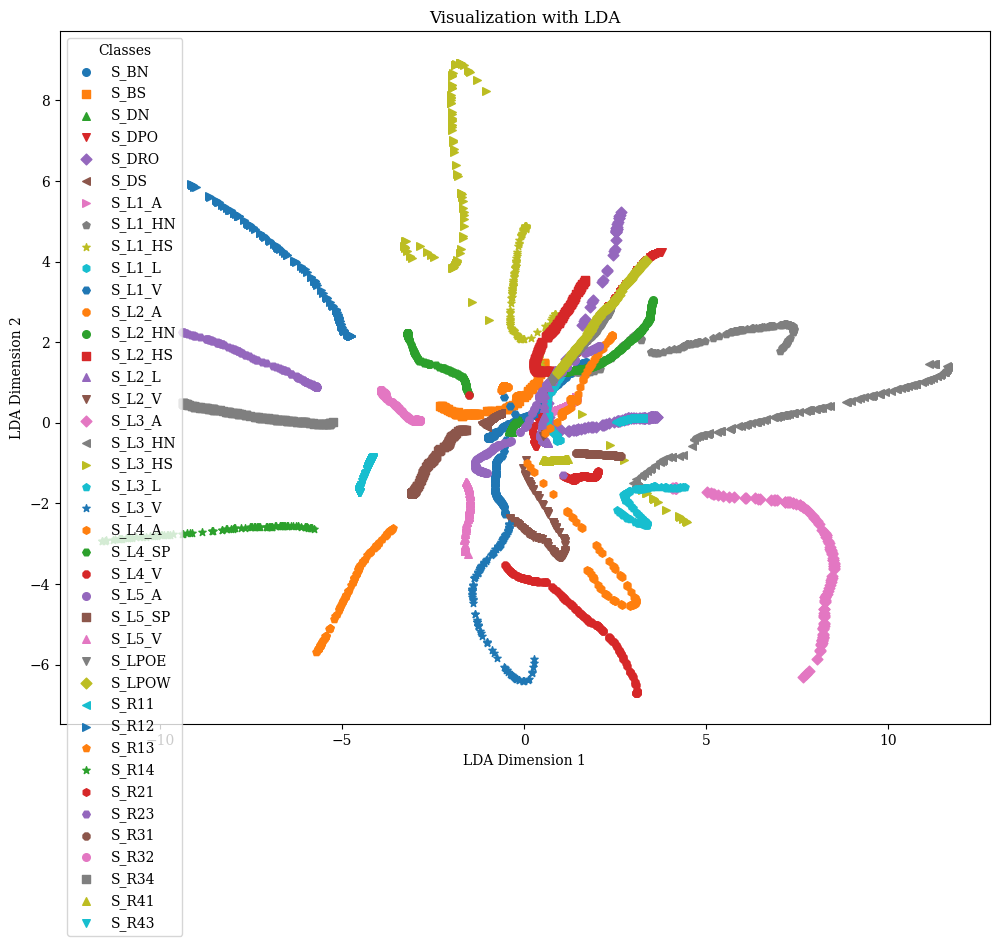

In [34]:
plot_latent_space(sampled_latent_representations, np.array(sampled_classes[0]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_label', many_classes=True, grid_view=False)

Saved grid plot to ../experiments/experiment_2/dimensionality_reduction_latent_space_type_grid.png


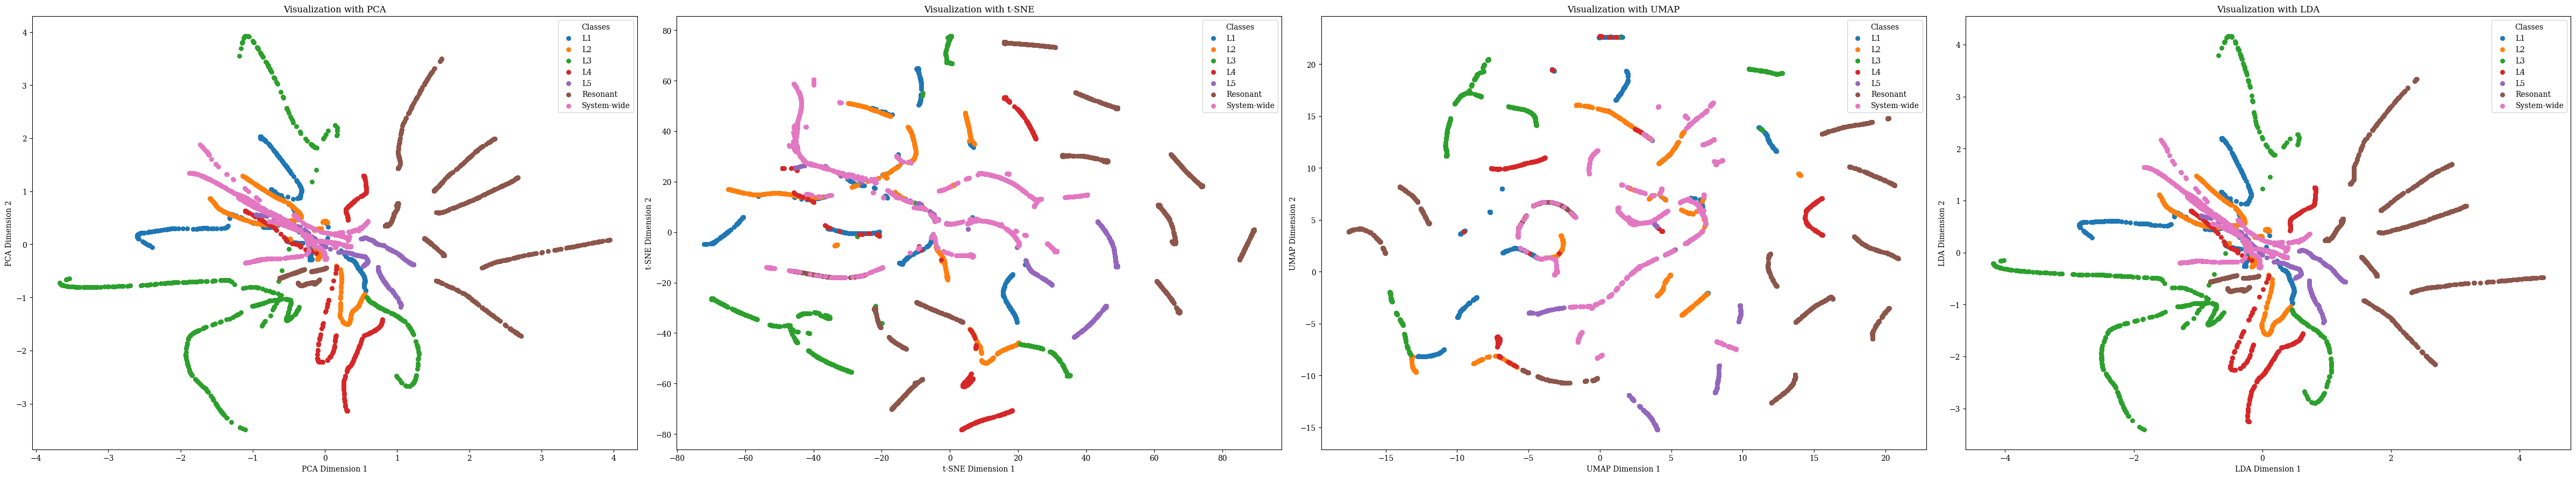

In [35]:
plot_latent_space(sampled_latent_representations, np.array(sampled_classes[1]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_type')

Saved grid plot to ../experiments/experiment_2/dimensionality_reduction_latent_space_subtype_grid.png


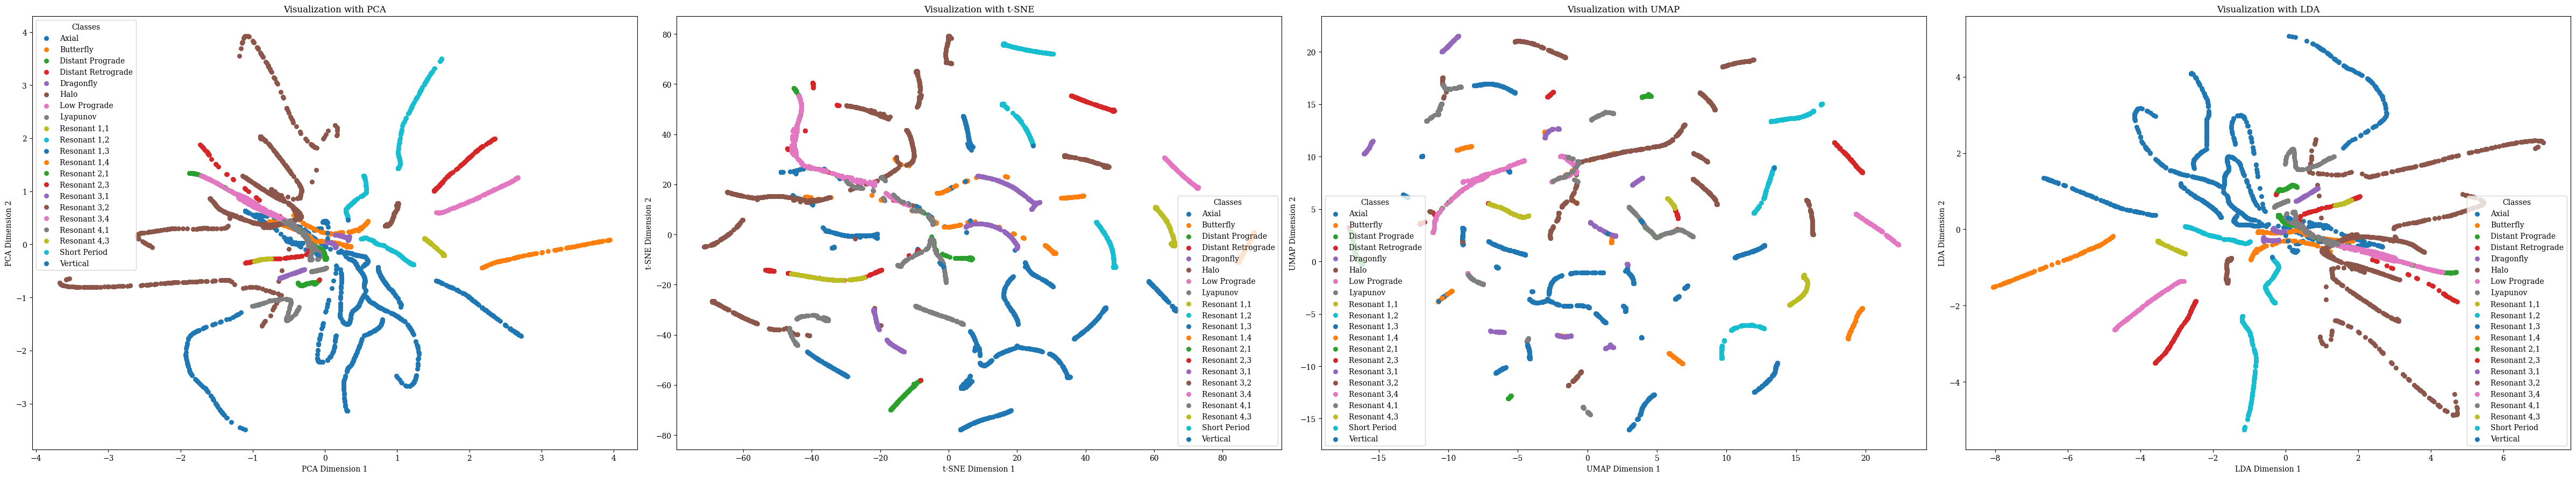

In [36]:
plot_latent_space(sampled_latent_representations, np.array(sampled_classes[2]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_subtype')

Saved grid plot to ../experiments/experiment_2/dimensionality_reduction_latent_space_direction_grid.png


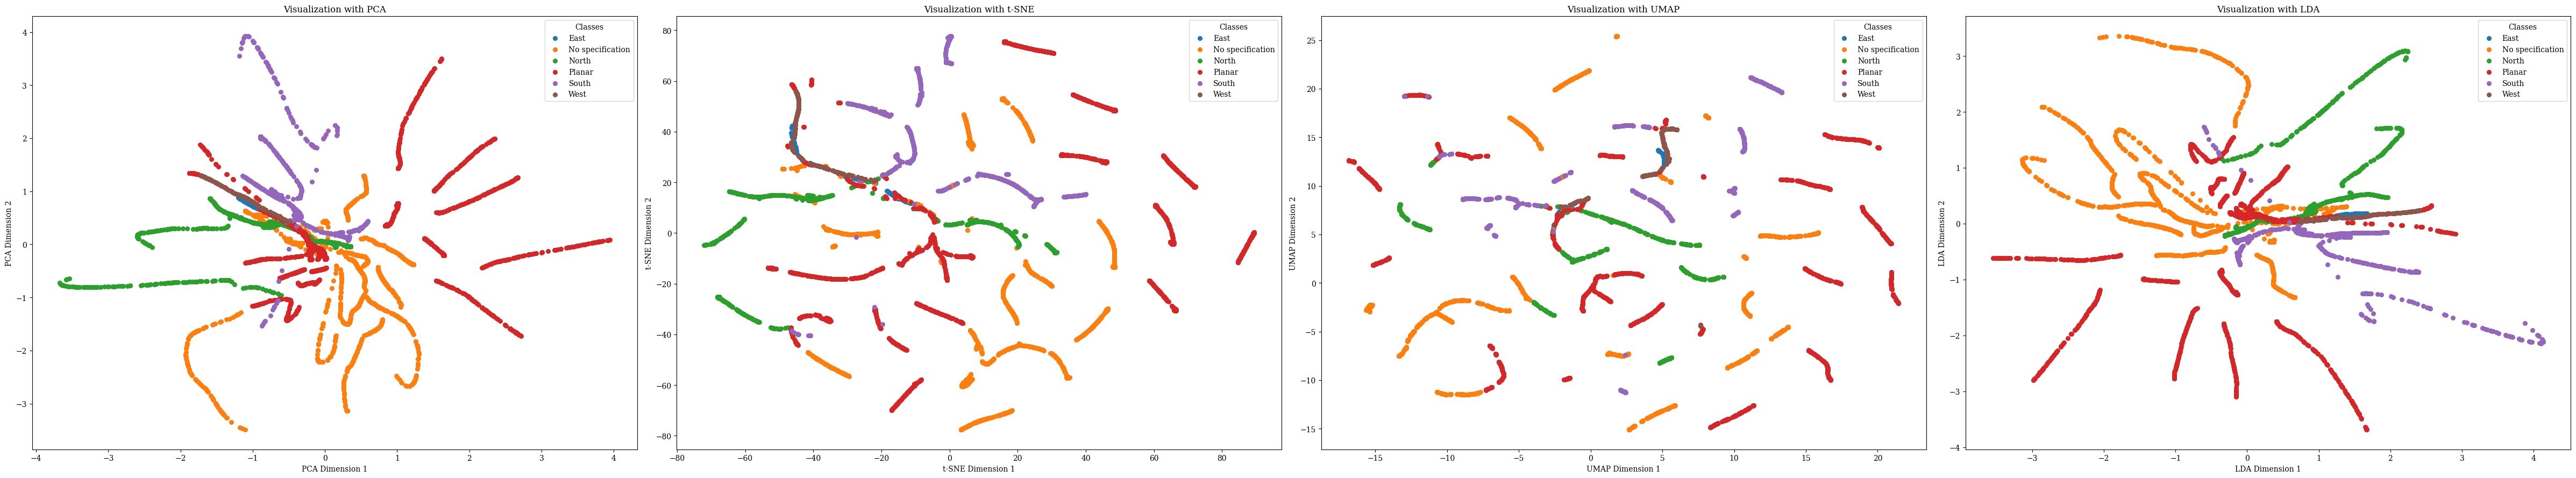

In [37]:
plot_latent_space(sampled_latent_representations, np.array(sampled_classes[3]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_direction')

## Synthetic vs Real

121/160 [=====================>........] - ETA: 0s

160/160 [==============================] - 1s 4ms/step
Saved grid plot to ../experiments/experiment_2/combined_dimensionality_reduction_latent_space_grid.png


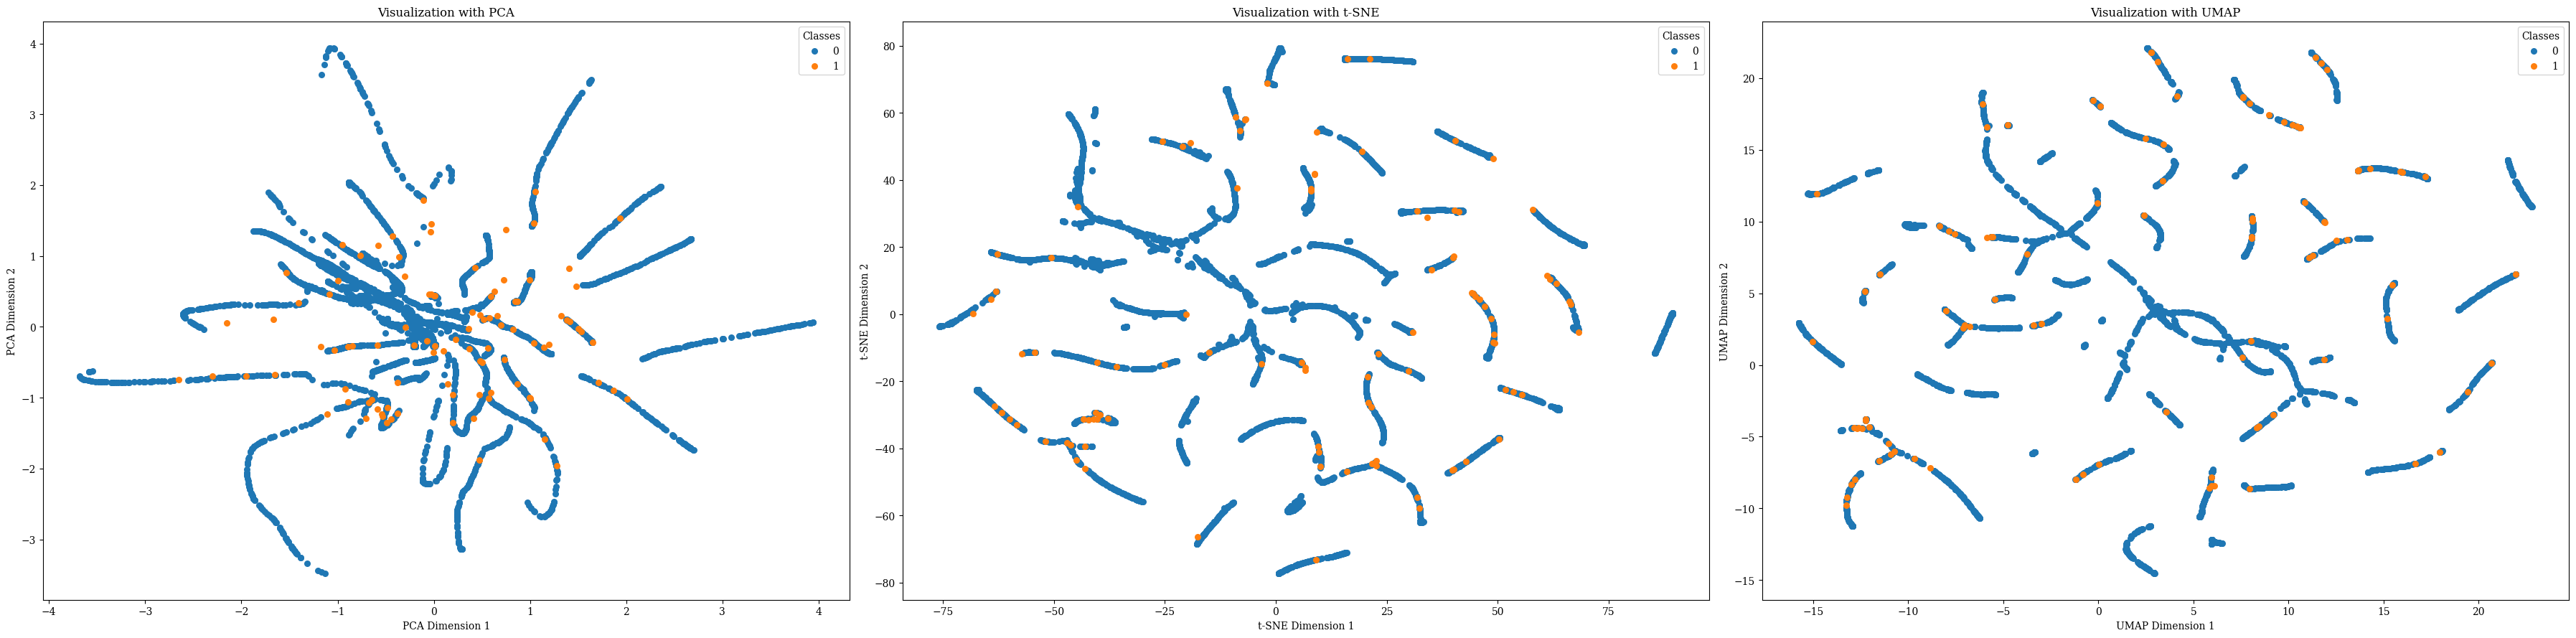

In [38]:
plot_combined_latent_space(sampled_data, generation, encoder, ['PCA','t-SNE','UMAP'], save_path=combined_latent_space_path, grid_view=True)

In [39]:
wandb.finish()

TypeError: field() got an unexpected keyword argument 'alias'

In [ ]:
# Save notebook as experiment
notebook_path = '/orbit-generation/nbs_experiments/01_cvae.ipynb'  # Update this to the path of your notebook
convert_notebook(notebook_path, experiment_folder, os.path.basename(experiment_folder), format='html')

An error occurred while converting the notebook to HTML:
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 5, in <module>
    from nbconvert.nbconvertapp import main
  File "/usr/local/lib/python3.8/dist-packages/nbconvert/__init__.py", line 6, in <module>
    from . import filters, postprocessors, preprocessors, writers
  File "/usr/local/lib/python3.8/dist-packages/nbconvert/filters/__init__.py", line 8, in <module>
    from .markdown import (
  File "/usr/local/lib/python3.8/dist-packages/nbconvert/filters/markdown.py", line 12, in <module>
    from .markdown_mistune import markdown2html_mistune
  File "/usr/local/lib/python3.8/dist-packages/nbconvert/filters/markdown_mistune.py", line 21, in <module>
    from nbconvert.filters.strings import add_anchor
  File "/usr/local/lib/python3.8/dist-packages/nbconvert/filters/strings.py", line 23, in <module>
    from nbconvert.preprocessors.sanitize import _get_default_css_sanitizer
  File "/usr/local/lib/py

CalledProcessError: Command 'jupyter nbconvert --to html "/orbit-generation/nbs_experiments/01_cvae.ipynb" --output "../experiments/experiment_3/experiment_3.html"' returned non-zero exit status 1.